<a href="https://colab.research.google.com/github/fsternini/anomaly-prediction/blob/development/anomaly_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [2]:
!git clone 'https://github.com/fsternini/anomaly-prediction.git'
%cd 'anomaly-prediction'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'anomaly-prediction'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (5/5), done.
/content/anomaly-prediction
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [9]:
!pip install pandas scipy colab-env

  Preparing metadata (setup.py) ... done
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3806 sha256=8d34a86dd4167b5f9bb4e2521fcf3b42f308b72bd33545307439352441635070
  Stored in directory: /root/.cache/pip/wheels/ae/36/4f/466c2cd4db5d08f317893a920c4a0f58a81459ee3bdb136d35
Successfully built colab-env


In [10]:
from scipy.io import loadmat
from google.colab import drive
import colab_env
import os,sys

drive.mount('/content/drive')

dataset_path = os.environ["ANOMALY_DATASET"]

Mounted at /content/gdrive
Mounted at /content/drive


In [11]:
# Replace 'your_file.mat' with the actual filename
file_name = 'C_Mod_for_nn.mat'

# Load the .mat file
data = loadmat(os.path.join(dataset_path,file_name))

# The variable `data` now contains a dictionary with keys corresponding to variable names in the .mat file
# For example, to access a variable named 'example_variable', you would use data['example_variable']

# Print the loaded data (keys) to understand its structure
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'shot', 'time', 'time_until_disrupt', 'v_loop', 'z_error', 'signal_names'])


In [19]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Oct  6 14:21:28 2019', '__version__': '1.0', '__globals__': [], 'Greenwald_fraction': array([[2.61671424e-01],
       [1.93636477e-01],
       [3.12397703e-21],
       ...,
       [1.67424858e-01],
       [1.69788092e-01],
       [1.66034207e-01]]), 'Mirnov_norm_btor': array([[1.2390554 ],
       [1.15398717],
       [3.54094219],
       ...,
       [0.16784951],
       [0.18845347],
       [0.1710373 ]]), 'Te_peaking_ECE': array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]]), 'beta_p': array([[ 0.14727603],
       [ 0.19911849],
       [-0.01403902],
       ...,
       [ 0.09726767],
       [ 0.10503101],
       [ 0.09966871]]), 'ip_error_normalized': array([[-0.1559327 ],
       [-0.21475341],
       [-0.66040082],
       ...,
       [-0.01495537],
       [-0.01148414],
       [-0.01281592]]), 'kappa': array([[1.57228386],
       [1.55385911],
       [1.69113302],
    

In [33]:
columns = []
for d in data["signal_names"]:
  columns.append(d[0][0])
print(columns)

['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'v_loop', 'z_error']


In [35]:
data_filt = {key: value for key, value in data.items() if '__' not in key}
data_filt.pop("signal_names")
#print(data_filt)

array([[array(['Greenwald_fraction'], dtype='<U18')],
       [array(['Mirnov_norm_btor'], dtype='<U16')],
       [array(['Te_peaking_ECE'], dtype='<U14')],
       [array(['beta_p'], dtype='<U6')],
       [array(['ip_error_normalized'], dtype='<U19')],
       [array(['kappa'], dtype='<U5')],
       [array(['li'], dtype='<U2')],
       [array(['lower_gap'], dtype='<U9')],
       [array(['n_equal_1_normalized'], dtype='<U20')],
       [array(['q95'], dtype='<U3')],
       [array(['radiated_fraction'], dtype='<U17')],
       [array(['v_loop'], dtype='<U6')],
       [array(['z_error'], dtype='<U7')]], dtype=object)

In [48]:
import numpy as np
for key, value in data_filt.items():
  data_filt[key]= np.squeeze(value)

In [49]:
import pandas as pd

df = pd.DataFrame(data_filt)
df.head()

,Greenwald_fraction,Mirnov_norm_btor,Te_peaking_ECE,beta_p,ip_error_normalized,kappa,li,lower_gap,n_equal_1_normalized,q95,radiated_fraction,shot,time,time_until_disrupt,v_loop,z_error
0,2.616714e-01,1.239055,NaN,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,1150915029,0.2850,0.0141,4.186112,-0.004279
1,1.936365e-01,1.153987,NaN,0.199118,-0.214753,1.553859,1.470170,0.077982,0.001154,5.151639,1.701884,1150915029,0.2900,0.0091,3.770813,0.000107
2,3.123977e-21,3.540942,NaN,-0.014039,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,1150915029,0.2950,0.0041,7.111877,0.004702
3,1.853891e-01,0.208537,NaN,0.001086,-0.264637,1.331522,1.553290,0.094562,0.001163,4.707932,0.665236,1120131006,0.1895,0.0150,-2.671509,-0.007156
4,1.804675e-01,0.194072,NaN,0.024498,-0.246736,1.388904,1.564471,0.106611,0.001136,4.985343,0.510057,1120131006,0.1945,0.0100,-2.581421,-0.018531


In [54]:
df.set_index(["shot","time"],inplace=True)

In [55]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  
shot       time                                                               
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279  
           0.2900           1.701884              0.0091  3.770813  0.000107  
           0.2950           0.276097              0.0041  7.111877  0.004702  
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156  
           0.1945           0.510057              0.0100 -2.581421 -0.018531

In [56]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
dtype: int64

In [59]:
df[df['time_until_disrupt']<0.03].count()

Greenwald_fraction      5941
Mirnov_norm_btor        5959
Te_peaking_ECE          1925
beta_p                  5959
ip_error_normalized     5959
kappa                   5958
li                      5959
lower_gap               5959
n_equal_1_normalized    5959
q95                     5956
radiated_fraction       5959
time_until_disrupt      5959
v_loop                  5959
z_error                 5959
dtype: int64

In [60]:
df["disrupt_30ms"]=False

In [64]:
df.loc[df['time_until_disrupt']<0.03, "disrupt_30ms"]=True

In [65]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  \
shot       time                                                                
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279   
           0.2900           1.701884              0.0091  3.770813  0.000107   
           0.2950           0.276097              0.0041  7.111877  0.004702   
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156   
           0.1945           0.510057              0.0100 -2.581421 -0.018531   

                   disrupt_30ms  
shot       time                  
1150915029 0.2850          True  
           0.2900          True  
           0.2950          True  
1120131006 0.1895          True  
           0.1945          True

In [66]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
disrupt_30ms            479692
dtype: int64

In [112]:
df.isna().sum()

Greenwald_fraction         455
Mirnov_norm_btor            72
Te_peaking_ECE          141680
beta_p                       0
ip_error_normalized          0
kappa                        1
li                           0
lower_gap                    0
n_equal_1_normalized         0
q95                          3
radiated_fraction          532
time_until_disrupt      400863
v_loop                       0
z_error                      0
disrupt_30ms                 0
dtype: int64

In [113]:
df.drop(columns=["time_until_disrupt","Te_peaking_ECE"],inplace=True)

In [115]:
df.isna().sum()

Greenwald_fraction      455
Mirnov_norm_btor         72
beta_p                    0
ip_error_normalized       0
kappa                     1
li                        0
lower_gap                 0
n_equal_1_normalized      0
q95                       3
radiated_fraction       532
v_loop                    0
z_error                   0
disrupt_30ms              0
dtype: int64

In [116]:
df.dropna(inplace=True)

In [118]:
df.count()

Greenwald_fraction      478630
Mirnov_norm_btor        478630
beta_p                  478630
ip_error_normalized     478630
kappa                   478630
li                      478630
lower_gap               478630
n_equal_1_normalized    478630
q95                     478630
radiated_fraction       478630
v_loop                  478630
z_error                 478630
disrupt_30ms            478630
dtype: int64

In [119]:
df["disrupt_30ms"].value_counts()

disrupt_30ms
False    472692
True       5938
Name: count, dtype: int64

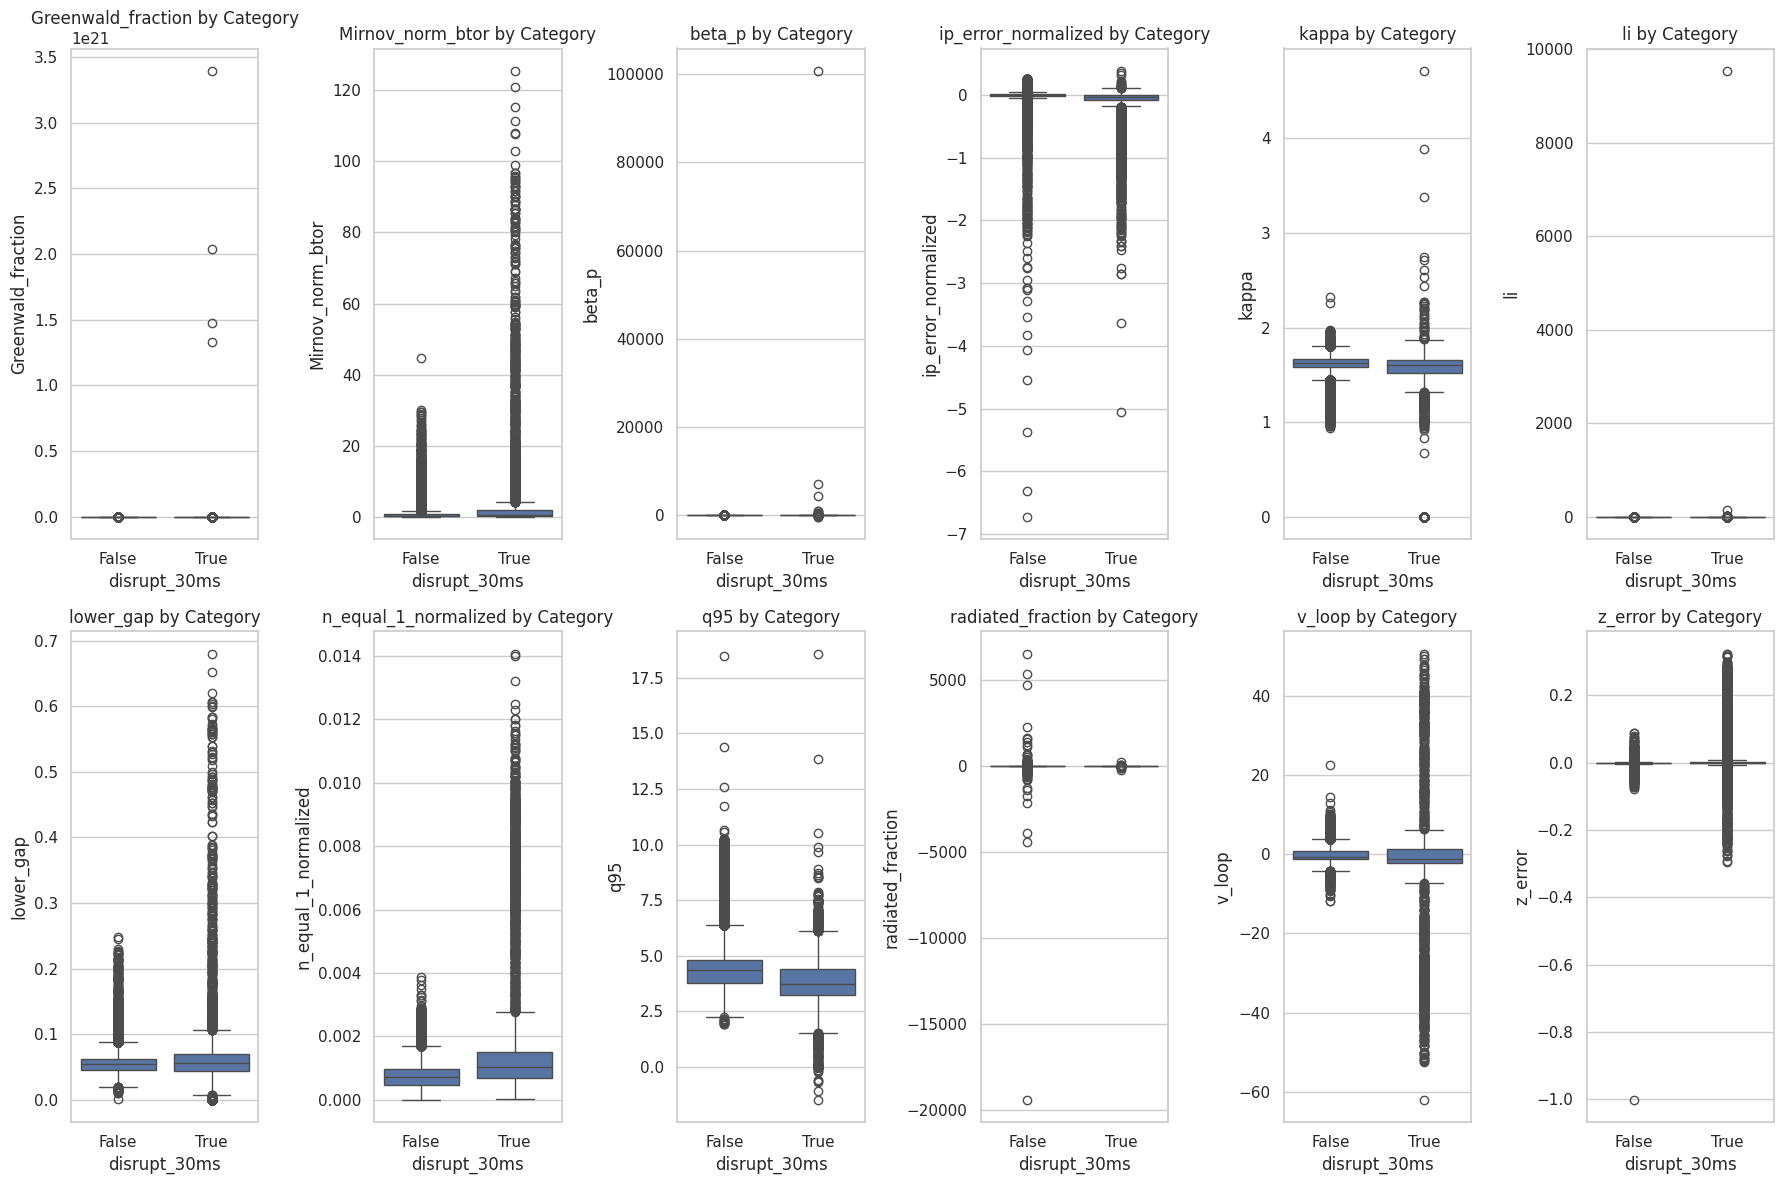

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))  # Set the figure size for better visibility

for index, feature in enumerate(df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(df.select_dtypes(include=[np.number]).columns)/2), index)  # Adjust subplot position
    sns.boxplot(x='disrupt_30ms', y=feature, data=df)
    plt.title(f'{feature} by Category')

plt.tight_layout()
plt.show()

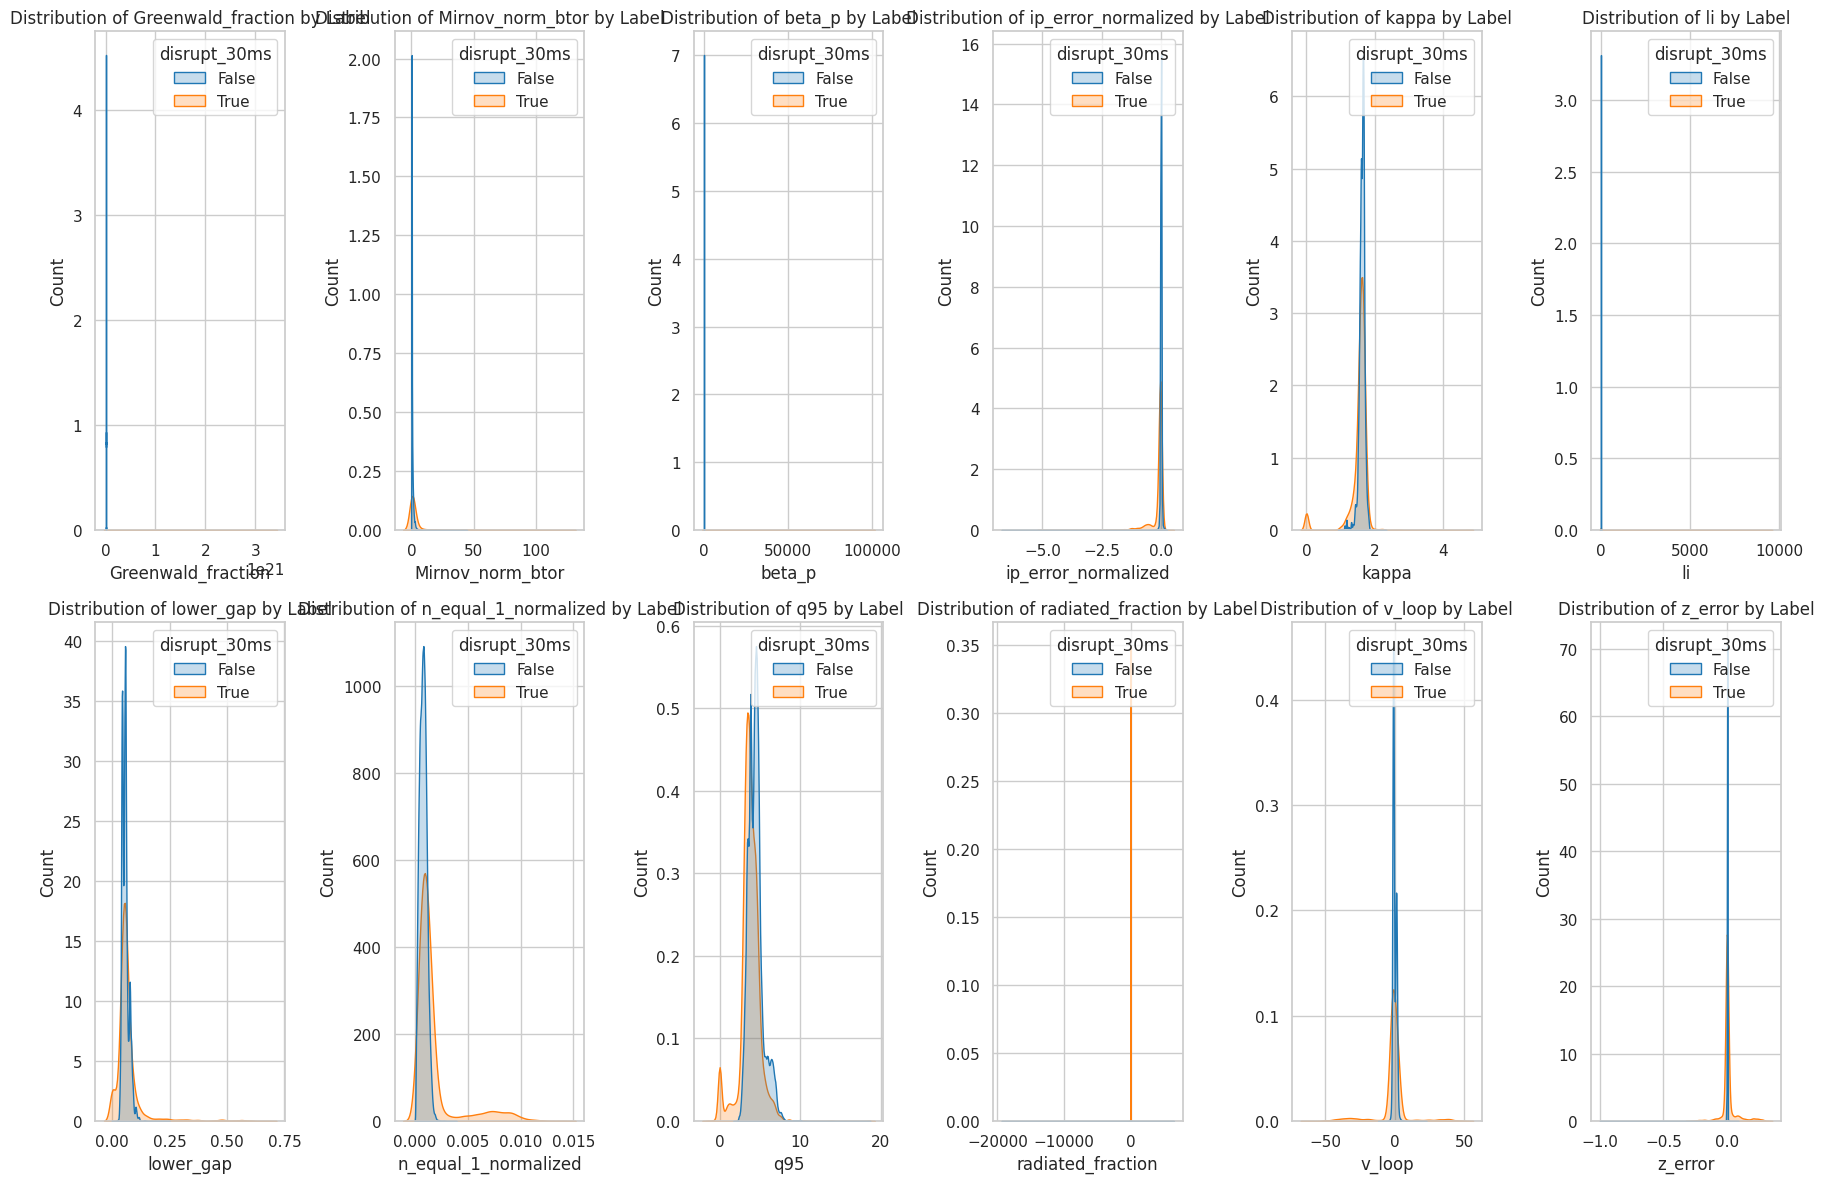

In [121]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

# Loop through each numeric column
numeric_columns = df.select_dtypes(include='number').columns
num_plots = len(numeric_columns)

for index, col in enumerate(numeric_columns, start=1):
    plt.subplot(2, int(num_plots/2), index)
    sns.kdeplot(data=df, x=col, hue='disrupt_30ms', fill=True, common_norm=False, palette='tab10')
    plt.title(f'{col} by Label')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [84]:
from sklearn.model_selection import train_test_split


In [85]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['disrupt_30ms'], random_state=42)

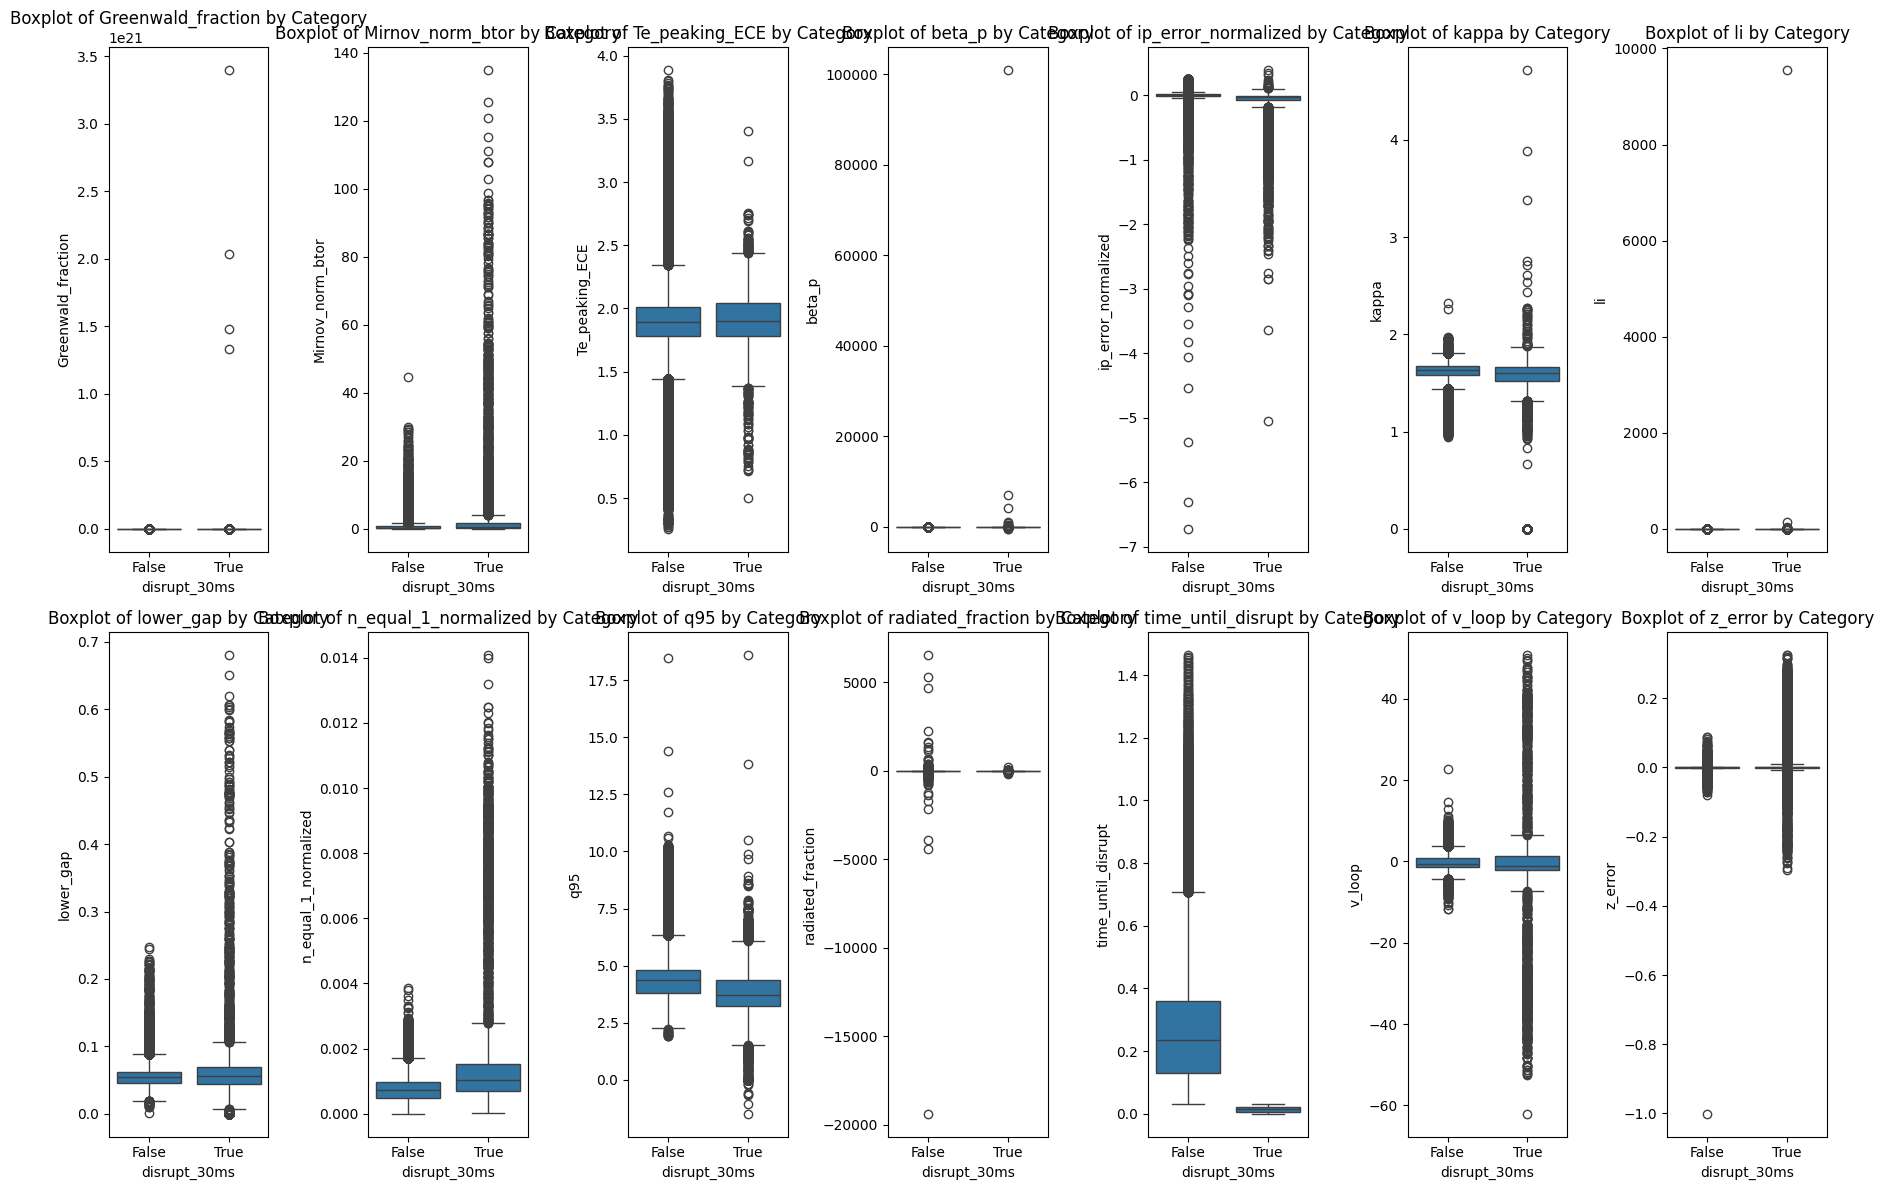

In [86]:
plt.figure(figsize=(18, 12))  # Set the figure size for better visibility

for index, feature in enumerate(train_df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(train_df.select_dtypes(include=[np.number]).columns)/2), index)  # Adjust subplot position
    sns.boxplot(x='disrupt_30ms', y=feature, data=train_df)
    plt.title(f'Boxplot of {feature} by Category')

plt.tight_layout()
plt.show()

#Anomaly detection

In [104]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Generate or load your dataset
np.random.seed(42)

# Normalize data to improve model performance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df.drop(columns=["time_until_disrupt","disrupt_30ms"]))

In [109]:

# Initialize and fit the Isolation Forest
isolation_forest = IsolationForest(contamination=0.02, random_state=42)
isolation_forest.fit(scaled_data)


ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:

# Predict anomalies: -1 indicates an anomaly, 1 indicates normal
anomaly_predictions = isolation_forest.predict(scaled_data)

# Attach predictions to the DataFrame
df['anomaly'] = anomaly_predictions

# Display the count of normal and anomalous points
print("Counts of anomaly predictions:")
print(df['anomaly'].value_counts())

# Optionally inspect the first few anomalies
anomalies_detected = df[df['anomaly'] == -1]
print("\nSample of detected anomalies:")
print(anomalies_detected.head())
